In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Mathematical Tables ##

There is a surprising amount of interesting mathematics involved in the construction of numerical tables (e.g. trigonometric tables, or tables of square roots or logs).  Nowadays the tables themselves are generally uninteresting, but the mathematical history is fascinating and the techniques can be surprisingly relevant even with modern computational tools.  It's not infrequent that you want an approximation to some function (e.g. the mass enclosed within a specific radius, an integral of some physically interesting function, etc.) inside a loop, an ODE integration or to get started on some other problem and many of the methods below serve as standard workhorses.

## Square root ##

One of the most useful set of tables was a square root table, as taking square roots shows up in other places, like trig tables or log tables.  So we'll start with this.  One basic idea is to make a guess for the square root and then use [Newton-Raphson](https://en.wikipedia.org/wiki/Newton%27s_method) iteration to improve it, i.e. to obtain $\sqrt{a}$ we iterate
$$
  x_{n+1} = \frac{1}{2}\left( x_n + \frac{a}{x_n}\right)
$$
This converges quadratically near the solution.  Given a value for $\sqrt{2}$ we can clearly reduce the range we need to actually solve to $[1/\sqrt{2},\sqrt{2}]$ by successive multiplications or divisions of $a$ by 2 (keeping track of the factors).

Interestingly this algorithm was known to the Babylonians, and tables of square roots go back more than 3 millenia (check out [YBC7289](https://en.wikipedia.org/wiki/YBC_7289)).  Exactly how the square root was computed is not entirely clear, since doing long division base 60 with Babylonian methods is _complex_.  But any modern root finding method would work, so they may even have used bisection (which involves only averaging and squaring numbers, in this case, and hence is relatively easy).

Suppose we've reduced our range to $a\in[2^{-1/2},2^{1/2}]$.  We want to start with a close guess for $\sqrt{a}$.  On a modern computer people actually use clever bit fiddling tricks, based on how IEEE floating point numbers are stored.  We can imagine a simple polynomial first guess.

In [2]:
# See how closely various polynomials approximate sqrt{a}.
aa = np.linspace(1/np.sqrt(2.0),np.sqrt(2.0),50)
for iorder in [1,2,3]:
    pp = np.poly1d(np.polyfit(aa,np.sqrt(aa),iorder))
    er = np.max(np.abs(pp(aa)-np.sqrt(aa))/np.sqrt(aa))
    print(pp," has fractional error ",er)

 
0.4899 x + 0.5052  has fractional error  0.012748382806078897
         2
-0.1182 x + 0.7405 x + 0.3774  has fractional error  0.0012774087591056883
         3          2
0.05718 x - 0.3001 x + 0.929 x + 0.3139  has fractional error  0.00014793501392770648


It's not clear that the increased accuracy of quadratic or cubic polynomials actually helps in this case, we may was well start with just linear.

In [3]:
def my_sqrt(a):
    """Implement a simple sqrt algorithm, assuming 1/sqrt{2}<a<sqrt{a}.
       Returns both the 1-iteration and 2-iteration result."""
    xx = 0.5052 + 0.4899 * a
    x1 = 0.5*(xx+a/xx)
    x2 = 0.5*(x1+a/x1)
    return( (x1,x2) )
    #
# Note how quickly Newton converges once you get close.  In this case we
# need just one or two iterations.
for a in np.linspace(0.71,1.4,10):
    exact = np.sqrt(a)
    x1,x2 = my_sqrt(a)
    print("a={:f} has my_sqrt={:f} ({:f}% error) or {:f} ({:f}% error)".\
          format(a,x1,100*(x1-exact)/exact,x2,100*(x2-exact)/exact))

a=0.710000 has my_sqrt=0.842679 (0.007544% error) or 0.842615 (0.000000% error)
a=0.786667 has my_sqrt=0.886950 (0.000841% error) or 0.886942 (0.000000% error)
a=0.863333 has my_sqrt=0.929158 (0.000059% error) or 0.929157 (0.000000% error)
a=0.940000 has my_sqrt=0.969544 (0.000783% error) or 0.969536 (0.000000% error)
a=1.016667 has my_sqrt=1.008312 (0.001252% error) or 1.008299 (0.000000% error)
a=1.093333 has my_sqrt=1.045637 (0.001059% error) or 1.045626 (0.000000% error)
a=1.170000 has my_sqrt=1.081670 (0.000462% error) or 1.081665 (0.000000% error)
a=1.246667 has my_sqrt=1.116542 (0.000014% error) or 1.116542 (0.000000% error)
a=1.323333 has my_sqrt=1.150367 (0.000371% error) or 1.150362 (0.000000% error)
a=1.400000 has my_sqrt=1.183242 (0.002183% error) or 1.183216 (0.000000% error)


In [4]:
# Now we could wrap this in a more general routine which did the reduction
# in range as well.  We'd generally be more clever than the below, but this
# illustrates the point.
def my_sqrt(a):
    """Implements a square root algorithm, including range reduction."""
    sqrt2  = 1.4142135623730951  # Would need to be worked out in advance.
    aa,fac = a,1.0
    while aa>16:
        aa,fac = aa/16.0,fac*4.0
    while aa> 4:
        aa,fac = aa/4.0,fac*2.0
    while aa> 2:
        aa,fac = aa/2.0,fac*sqrt2
    while aa<1./16.:
        aa,fac = aa*16,fac/4.0
    while aa<1./4.:
        aa,fac = aa*4.,fac/2.0
    while aa<1./2.:
        aa,fac = aa*2,fac/sqrt2
    xx = 0.5052 + 0.4899 * aa
    xx = 0.5*(xx+aa/xx)
    xx = 0.5*(xx+aa/xx)
    return(xx*fac)
    #
for a in np.logspace(-2.0,2.0,10):
    ex = np.sqrt(a)
    xx = my_sqrt(a)
    print("a={:8.3f} has my_sqrt={:8.4f} ({:10.8f}% error)".\
          format(a,xx,100*(xx-ex)/ex))

a=   0.010 has my_sqrt=  0.1000 (0.00000359% error)
a=   0.028 has my_sqrt=  0.1668 (0.00000000% error)
a=   0.077 has my_sqrt=  0.2783 (0.00000674% error)
a=   0.215 has my_sqrt=  0.4642 (0.00000000% error)
a=   0.599 has my_sqrt=  0.7743 (0.00001200% error)
a=   1.668 has my_sqrt=  1.2915 (0.00000388% error)
a=   4.642 has my_sqrt=  2.1544 (0.00000000% error)
a=  12.915 has my_sqrt=  3.5938 (0.00000195% error)
a=  35.938 has my_sqrt=  5.9948 (0.00000000% error)
a= 100.000 has my_sqrt= 10.0000 (0.00000090% error)


What would you do if you could only multiply, not divide?  This is still the case on some microcontrollers (though fewer and fewer nowadays). You could spend some time coming up with a Newton iteration for inverse, but that's Newton inside Newton and gets complicated.  The other thing is to think about $1/\sqrt{a}$.  If I could find this, multiplication by $a$ gives $\sqrt{a}$.  Note solving $f(x)=1/x^2 - a = 0$ using Newton's method gives the following iteration
$$
  x_{n+1} = x_n - \frac{x_n^{-2}-a}{-2x_n^{-3}} = x_n + \frac{1}{2}\left(x_n-ax_n^2\right) = \frac{1}{2}x_n\left( 3 - ax_n^2 \right)
$$
which involves only multiplications.

(As an aside, check out [this code](https://en.wikipedia.org/wiki/Fast_inverse_square_root) for a fast inverse square root with the highly amusing comments.)

You can find more ideas for computing square roots at [this Wikipedia page](https://en.wikipedia.org/wiki/Methods_of_computing_square_roots).
It turns out that many "fixed point algorithms" look and behave like Newton's method, so the intuition gained here can be carried over to other areas.

## Trig tables ##

Tables of sines, cosines, tangents, etc. have been in use for a long time, and clearly come into many practical calculations.  Early on (ancient Greek times) they were "tables of chords" of circles, but it's essentially the same thing.

We could do this by Taylor series expansion (see below), but instead consider the following method.  Simple geometry is enough to tell us sine and cosine for a number of standard angles: $0^\circ$, $30^\circ$, $45^\circ$, $60^\circ$ and $90^\circ$.  Clearly symmetry allows us to determine the functions for all other ranges once we know sine and cosine for $[0^\circ,90^\circ]$.

We know the sine and cosine addition theorems, so for example:
$$
  \sin(A+B) = \sin A \cos B + \cos A \sin B
$$
and this allows us to get sine and cosine for $15^\circ$ and $75^\circ$ easily.  At this point we could get sine and cosine for $7.5^\circ$ using the double-angle formula and our results for $15^\circ$.  But we know sine and cosine are smooth, so what if we just fit a polynomial to these results?  How well would we do?

Back in the day, people would have used a [Newton divided difference polynomial](https://en.wikipedia.org/wiki/Newton_polynomial) for their interpolation.  Let's have NumPy do the work!

            6           5           4          3             2
-0.0009654 x + 0.01031 x - 0.00209 x - 0.1655 x - 0.0003304 x + 1 x + 2.832e-16


Text(0, 0.5, 'Fractional error (percent)')

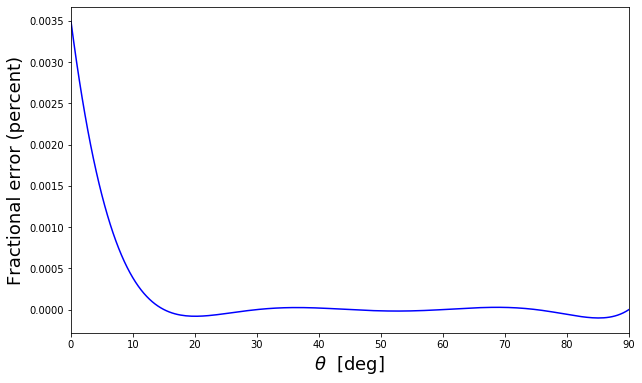

In [5]:
# Imagine we have the sine table at 15 degree steps.
tt = np.array([0.0,15.,30.,45.,60.,75.,90.]) * np.pi/180.
st = np.sin(tt)
# Now fit a polynomial through this.  We have 7 points, so
pp = np.poly1d( np.polyfit(tt,st,6) )
print(pp)
# How well does this do?
tt = np.linspace(1e-4,np.pi/2.,200)
er = (pp(tt)-np.sin(tt))/(np.sin(tt)+1e-8)
# Let's plot the percentage error
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(tt*180./np.pi,100*er,'b-')
ax.set_xlim([0,90])
ax.set_xlabel(r'$\theta$  [deg]',fontsize=18)
ax.set_ylabel(r'Fractional error (percent)',fontsize=18)

So this is good enough for about 4 digits of accuracy!  Not too shabby.  If we went down to 7.5 degrees we could improve this even more.  Also, we could probably use a power series for smaller values of $\theta$ to improve accuracy to the left of the plot.  And we would probably interpolate across pieces of the table rather than finding a global polynomial fit.

This kind of Newton-polynomial method was widely used.  Perhaps the coolest example was the Babbage difference engine, which used to be on display in the [Computer History Museum](http://www.computerhistory.org/) in Palo Alto, but is now only in the London science museum.  The principle of difference engines is [explained here](http://www.computerhistory.org/babbage/howitworks/).

What if we fit a spline to the points, instead of a polynomial?

Text(0, 0.5, 'Fractional error (percent)')

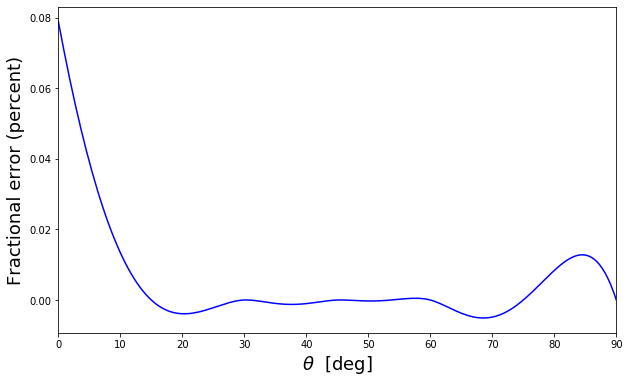

In [6]:
# Imagine we have the sine table at 15 degree steps.
tt = np.array([0.0,15.,30.,45.,60.,75.,90.]) * np.pi/180.
st = np.sin(tt)
# Now fit a Spline through this.
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
ss = Spline(tt,st)
# How well does this do?
tt = np.linspace(1e-5,np.pi/2.,200)
er = (ss(tt)-np.sin(tt))/(np.sin(tt)+1e-8)
# Let's plot the percentage error
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(tt*180./np.pi,100*er,'b-')
ax.set_xlim([0,90])
ax.set_xlabel(r'$\theta$  [deg]',fontsize=18)
ax.set_ylabel(r'Fractional error (percent)',fontsize=18)

Interestingly the polynomial approximation does better than the spline!  When fitting splines we shouldn't use equally spaced $x$-coordinates, but in many cases we actually do so this is a somewhat fair comparison "in practice".

Viewed another way, sometimes knowing the theory is better than "machine learning".

What if we start to use some actual mathematical theory?  We can Taylor expand $\sin x$ to any order we like.  What if we use an economized power series?  The basic idea is to start with our Taylor series
$$
  \sin x = x - \frac{x^3}{3!} + \frac{x^5}{5!} - \frac{x^7}{7!} + \cdots
$$
carried out to very high order.  Map the $x$-range of interest into $-1\le y\le 1$.  Convert the powers of $y$ into [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials) ($T_n$), truncate the expansion and then convert back to powers of $y$ and hence $x$.  (This is actually how people first coded these things up back in the good old days of digital computers.)

The remapping step can be implemented by looking at $\sin(\pi y/2)$ over the range $-1\le y\le 1$. So
$$
  \sin\frac{\pi y}{2} \approx \frac{\pi}{2}y - \frac{\pi^3y^3}{48} + \frac{\pi^5y^5}{3840}
  = 1.13613 T_1 - 0.136587 T_3 + 0.00498079 T_5
$$
If we truncate at $T_3$ (i.e. throw away $T_5$) we get
$$
  \sin\frac{\pi y}{2}\approx  1.13613 T_1 - 0.136587 T_3
  = 1.54589 y - 0.546348 y^3 = 0.984146 x - 0.140965 x^3
$$

In [7]:
# How well does this work?
pp = np.poly1d([-0.140965,0.0,0.984146,0.0])
xx = np.linspace(0.,np.pi/2.,100)
ex = np.sin(xx)
me = pp(xx)
print("Maximum error, {:f}%".format(100*np.max(np.abs(me-ex)/(me+1e-10))))

Maximum error, 1.610340%


That's pretty good for a 2 term approximation!  Note with a little cleverness this requires only a very few multiplications and additions.

What if we go to $x^7$?  The series becomes
$$
  \sin x \approx 0.999996 x - 0.166647 x^3 + 0.00830502 x^5 - 0.000183114 x^7
$$
How well does that do?

In [8]:
pp = np.poly1d([-0.000183114,0,0.00830502,0,-0.166647,0,0.999996,0])
xx = np.linspace(0.,np.pi/2.,100)
ex = np.sin(xx)
me = pp(xx)
print("Maximum error, {:f}%".format(100*np.max(np.abs(me-ex)/(me+1e-10))))

Maximum error, 0.000400%


So that's much better than our $15^\circ$ degree polynomial interpolation, but it would be more work to evaluate than interpolating from a table of numbers.  But it could be used to construct such a table!  More interestingly, this is how standard math libraries (or hardware on high-end chips) do trig functions.  Note if we call the coefficients in the $\sin x$ expansion above $c_n$ we could write
$$
  \sin x \approx x*(c_1+x^2*(c_3+x^2*(c_5+x^2*c_7)))
$$
which involves 4 multiplications and 3 additions!  Compare the coefficients with the source code [here](http://www.netlib.org/fdlibm/k_sin.c), which goes to 13th order.

Another thing about Chebyshev expansions is that if you're fitting tabulated data with a series of polynomials, using orthogonal polynomials (of which Chebyshev is an example) then the condition number of the matrix you need to invert is generally **much** lower than if you use monomials like $x^n$.

Not directly relevant to us here, but if you're curious check out the [CORDIC](https://en.wikipedia.org/wiki/CORDIC) method for solving sine and cosine functions using the fact that computers are very good at dividing by 2.

Also, if you like to read about how sometimes the simplest steps cause problems, take a look at the problems with the built-in sine routine on Intel processors at [Intel Underestimates Error Bounds by 1.3 quintillion](https://randomascii.wordpress.com/2014/10/09/intel-underestimates-error-bounds-by-1-3-quintillion/)




## Chebyshev economization ##

One can do the economization of power series entirely automatically with standard numerical routines, but just for fun here's a method using NumPy's polynomial class.

In [9]:
# Set up a table of Chebyshev polynomials.
Tn = [ np.poly1d([1.0]) , np.poly1d([1.0,0.0]) ]
twox = np.poly1d([2.0,0.0])
for n in range(2,11):
    Tn.append( twox*Tn[-1] - Tn[-2] )
# Print the first few Chebyshev polynomials, just for fun.
for pp in Tn[:4]:
    print(pp)

 
1
 
1 x
   2
2 x - 1
   3
4 x - 3 x


In [10]:
# Ok, now set up a list of coefficients of the first term.
leading = [1.] + [2.**i for i in range(10)]
# Make up a series to approximate.  Here we'll do cosine.
coeff = [1.0,0.0,-1./2.,0.0,1./24.,0.0,-1./720.,0.0,1./40320.,0.0,-1./3628800.]
# We want this to be cos(pi x/2) to do the range reduction:
coeff = np.array(coeff)*np.array([(np.pi/2)**i for i in range(len(coeff))])
# Turn this into a polynomial.
cosx = np.poly1d(coeff[::-1])
print(cosx)
# Now we economize it.
# Subtract off the Chebyshev polynomials for the highest terms, here we do 2.
for i in range(2):
    degree  = len(cosx.c)-1
    cosx   -= cosx.c[0]/leading[degree] * Tn[degree]
    print(cosx)

           10             8           6          4         2
-2.52e-05 x  + 0.0009193 x - 0.02086 x + 0.2537 x - 1.234 x + 1
           8           6          4         2
0.0008563 x - 0.02081 x + 0.2536 x - 1.234 x + 1
         6          4         2
-0.0191 x + 0.2526 x - 1.233 x + 1


In [11]:
# Now we can test it.
xx = np.linspace(0.,1.,100)
ex = np.cos(xx*np.pi/2)
me = cosx(xx)
print("Maximum error, {:f}%".format(100*np.max(np.abs(me-ex)/(me+1e-10))))

Maximum error, 0.020235%


## Logarithm ##

The final set of tables we'll consider here are log tables.  This is included primarily because the method first developed is so slick it just feels like the kind of thing every geek should know.  Back in 1624 [Henry Briggs](https://en.wikipedia.org/wiki/Henry_Briggs_(mathematician)) published his "Arithmetica Logarithmica", containing the logs of thirty thousand natural numbers to fourteen decimal places.  This was worked out with quill pen!  How did he do it?

Some are easy.  If I knew $\ln 2$ and $\ln 3$ I would know $\ln 6$, $\ln 12$, etc.  So I'm really only interested in the primes.  We know how to compute logs for numbers close to 1 by Taylor expansion.  If we know some logs, e.g. $\ln a$, we can use $\ln(ax)=\ln a+\ln x$ to reduce the size of the argument.  We also know that $\ln\sqrt{x}=(1/2)\ln x$, and $\sqrt{x}$ is closer to $1$ than $x$ is.  So you first divide out by factors you know, then you take square roots until $x$ is close to $1$, then you use an approximation for $\ln(1+x)$.  And you do this 30,000 times!

For numbers close to 1 the Taylor expansion is:
$$
  \ln(1+x) = x - \frac{x^2}{2} + \frac{x^3}{3} - \frac{x^4}{4} + \cdots
$$
This series isn't as quickly converging as one might like, but it's okay for very small $x$.  One could "economize" this series too, but actually slightly slicker would be to do a [Pade approximant](https://en.wikipedia.org/wiki/Pad%C3%A9_approximant).  This is a rational function whose Taylor series agrees with the above up to a given order.  This requires slightly fewer multiplications and divisions.

You can quickly convince yourself that
$$
  \ln(1+x) \simeq \frac{x + x^2/2}{1+x+x^2/6}
$$
agrees with the Taylor series for $\ln(1+x)$ up to and including the $x^4$ term but only really requires us to square $x$ (and some additions and divisions).


In [12]:
# How close is our (2,2) Pade approximant to Log[1+x] for 0<x<sqrt{2}-1?
xx = np.linspace(0.1,np.sqrt(2.0)-1.0,200)
ex = np.log(1+xx)
pa = (xx+xx**2/2)/(1+xx+xx**2/6)
print("Worst case error is {:e} percent.".format(100*np.max(np.abs(pa-ex)/ex)))

Worst case error is 7.901302e-03 percent.


So we can compute $\ln x$ very accurately for $1<x<\sqrt{2}$.  Take out any factors you know the logs of if you want, but it's not really necessary.  If $x<1$ we use $\ln x^{-1}=-\ln x$.  We then take square roots until $x$ gets less than $\sqrt{2}$ and use our approximation.

In [13]:
def my_log(x):
    """Computes ln(x) using Brigg's method."""
    if x<1:
        return(-my_log(1./x))
    xx,fac = x,1.0
    while xx>np.sqrt(2.0):
        xx,fac = np.sqrt(xx),2*fac
    xx -= 1.0
    lnx = (xx+xx**2/2)/(1+xx+xx**2/6)
    return( fac*lnx )
    #
for x in np.arange(2,21):
    ex = np.log(x)
    me = my_log(x)
    er = (me-ex)/ex
    print("Ln({:4.1f})={:f} ({:f}% error)".format(x,me,100*er))

Ln( 2.0)=0.693092 (-0.007901% error)
Ln( 3.0)=1.098578 (-0.003133% error)
Ln( 4.0)=1.386185 (-0.007901% error)
Ln( 5.0)=1.609423 (-0.000906% error)
Ln( 6.0)=1.791735 (-0.001390% error)
Ln( 7.0)=1.945873 (-0.001931% error)
Ln( 8.0)=2.079389 (-0.002516% error)
Ln( 9.0)=2.197156 (-0.003133% error)
Ln(10.0)=2.302498 (-0.003775% error)
Ln(11.0)=2.397789 (-0.004437% error)
Ln(12.0)=2.484780 (-0.005112% error)
Ln(13.0)=2.564801 (-0.005799% error)
Ln(14.0)=2.638886 (-0.006494% error)
Ln(15.0)=2.707855 (-0.007196% error)
Ln(16.0)=2.772370 (-0.007901% error)
Ln(17.0)=2.833198 (-0.000544% error)
Ln(18.0)=2.890355 (-0.000589% error)
Ln(19.0)=2.944420 (-0.000635% error)
Ln(20.0)=2.995712 (-0.000680% error)


This is not quite up to Brigg's standards, but it's pretty good already!

There's a [funny story from the early days of electronic calculators](http://www.hpmemoryproject.org/an/pdf/A_Quarter_Century_at_HP110829.pdf) when people were first implementing these sorts of methods and CORDIC in particular:

"After the introduction of the 9100 our legal department got a letter from Wang saying that we had infringed on their patent. And I just sent a note back with the Briggs reference in Latin and it said, "It looks like prior art to me." We never heard another word."

Before we leave logarithms, you can often improve the convergence of a series by some clever manipulations.  The log is one example.  If we define $x=(1+y)/(1-y)$ then $x\in [1,\infty)$ maps to $y\in [0,1)$.  Further
$$
  \ln\left(\frac{1+y}{1-y}\right) = 2y\sum_{k=0}^\infty\frac{\left(y^2\right)^k}{2k+1}
$$
So this can help our program too.  If you're interested in these "series accelerations", you might want to look at [this article](https://projecteuclid.org/euclid.em/1046889587).

## Rational function expansion. ##

As a further example of the power of rational function expansion and Pade approximants, let's consider computing $\arctan x$.  By power series
$$
  \arctan x \approx x - \frac{1}{3}x^3 + \frac{1}{5}x^5 - \frac{1}{7}x^7 + \frac{1}{9}x^9 - \cdots
$$
You can match this power series with a ratio of polynomials as e.g.
$$
  \arctan x \approx \frac{x+(7/9)x^3+(64/945)x^5}{1+(10/9)x^2 + (5/21)x^4}
$$
How well do these two compare?

In [14]:
taylor = np.poly1d([1./9.,0,-1./7.,0,1./5.,0,-1./3.,0,1,0])  # Go through x^9 inclusive.
pnum   = np.poly1d([64./945.,0,7./9.,0,1,0])  # Highest power is x^5.
pden   = np.poly1d([5./21.,0,10./9.,0,1])     # Highest power is x^4.
#
for xx in np.linspace(0.5,1,6,endpoint=True):
    tapp = taylor(xx)
    papp = pnum(xx)/pden(xx)
    exact= np.arctan(xx)
    print("x={:6.2f}, Taylor={:8.5f} ({:12.4e}%), Pade={:8.5f} ({:12.4e}%)".\
          format(xx,tapp,100*(tapp-exact)/exact,papp,100*(papp-exact)/exact))

x=  0.50, Taylor= 0.46368 (  7.9083e-03%), Pade= 0.46365 (  8.2565e-05%)
x=  0.60, Taylor= 0.54067 (  4.6845e-02%), Pade= 0.54042 (  4.1171e-04%)
x=  0.70, Taylor= 0.61200 (  2.0853e-01%), Pade= 0.61074 (  1.5137e-03%)
x=  0.80, Taylor= 0.67982 (  7.5320e-01%), Pade= 0.67477 (  4.4476e-03%)
x=  0.90, Taylor= 0.74982 (  2.3200e+00%), Pade= 0.73290 (  1.1015e-02%)
x=  1.00, Taylor= 0.83492 (  6.3054e+00%), Pade= 0.78559 (  2.3863e-02%)


In [15]:
# And what happens if we keep going?
for xx in np.arange(1.0,2.51,0.25):
    tapp = taylor(xx)
    papp = pnum(xx)/pden(xx)
    exact= np.arctan(xx)
    print("x={:6.2f}, Taylor={:8.4f} ({:12.4e}%), Pade={:8.5f} ({:12.4e}%)".\
          format(xx,tapp,100*(tapp-exact)/exact,papp,100*(papp-exact)/exact))

x=  1.00, Taylor=  0.8349 (  6.3054e+00%), Pade= 0.78559 (  2.3863e-02%)
x=  1.25, Taylor=  1.3560 (  5.1325e+01%), Pade= 0.89702 (  1.0780e-01%)
x=  1.50, Taylor=  3.7244 (  2.7896e+02%), Pade= 0.98596 (  3.2199e-01%)
x=  1.75, Taylor= 13.1695 (  1.1523e+03%), Pade= 1.05939 (  7.3630e-01%)
x=  2.00, Taylor= 44.3365 (  3.9046e+03%), Pade= 1.12270 (  1.4045e+00%)
x=  2.25, Taylor=132.4922 (  1.1395e+04%), Pade= 1.17974 (  2.3574e+00%)
x=  2.50, Taylor=353.4851 (  2.9597e+04%), Pade= 1.23320 (  3.6048e+00%)


**Note** the catastrophic behavior of the power series expanded beyond its range of validity.  By contrast the Pade approximant is behaving quite well.  It's losing accuracy but not as catastrophically.  This behavior isn't guaranteed, but is typical.

There is a lot of interesting theory behind _why_ Pade approximants can do so well, involving complex analysis.  You can find this discussed in most books on numerical analysis (and whole courses in math departments!).

It should come as no surprise that you can combine Chebyshev expansions and rational function expansions together to approximate functions as ratios of series of Chebyshev polynomials.

## Rational function approximation ##

The theory of rational function approximation can quickly become quite complex, and there isn't an algorithm as simple as there is for Chebyshev economization.  But we're not usually in the situation where we're designing microcode for a mass-produced computer chip and billions of dollars rests on the optimality of our results.  Normally we have a function we want to approximate efficiently (e.g. in the inner loop of some ODE integration or something we need to apply to a huge data set) but we don't want to devote a year to the effort and can afford some slight imperfection.  In this case the following algorithm works "just fine".

We have a function, $f(x_i)$, that we can evaluate at predetermined points $\{x_i\}$.  Usually choosing equally spaced points is a bad idea (as it is for polynomial interpolation due to Runge's phenomenon), but there's no hard and fast rule.  Often roots of a Chebyshev polynomial work well.  We approximate this as
$$
  f(x) \approx \frac{\sum_{n=0}^{A} a_n x^n}{1+\sum_{n=1}^B b_n x^n}
  \quad \Rightarrow \quad
  f(x) + \sum_{n=1}^B b_n f(x)x^n = \sum_{n=0}^{A} a_n x^n
$$
How do we choose the $a_n$ and $b_n$?  Again, there's a "right" way which is pretty complicated but there's an easy way which is ... easy.  Let's minimize
$$
  \chi^2 = \sum_i \left[ f(x_i) + \sum_{n=1}^B b_n f(x_i)x_i^n - \sum_{n=0}^{A} a_n x_i^n \right]^2
$$
To make this easier to manipulate, define $c_\alpha=\{a_n,b_n\}$, i.e. to be $a_n$ for $n=0$ to $A$ and then $b_n$ for $n=1$ to B.  Similarly define $\phi_{i\alpha}$ to be $x_i^n$ for $0\le\alpha\le n$ and $-f(x_i)x_i^n$ for the remaining $B-1$ elements. This enables us to write
$$
  \chi^2 = \sum_i \left[ f(x_i) - \sum_{\alpha} c_\alpha \phi_{i\alpha} \right]^2
  \quad \Rightarrow \quad
  \frac{d\chi^2}{dc_\alpha} = \sum_i\left[ f(x_i) - \sum_{\beta} c_\beta \phi_{i\beta} \right] (-2\phi_{i\alpha})
$$
and $\chi^2$ is minimized when
$$
  c_\alpha = \left[ \sum_i \phi_{i\alpha}\phi_{i\beta}\right]^{-1} \sum_j f(x_j)\phi_{j\beta}
$$
Providing we aren't talking hundreds of terms, this is an almost trivial problem (note we can have an arbitrary number of $x_i$, the difficulty of the matrix inversion depends only on $A+B$).

### Example ###

Let's see how the code does at guessing $\arctan x$ if we don't tell it the power series.

In [16]:
## Code to find the coefficiencts of a rational approximation to a tabulated function.
def find_rational(xi,fxi,A,B):
    """Finds the coefficients of the rational approximation to f(x) [see above]."""
    # First set up phi_{j\alpha}.  Can do this with cleverness, but let's
    # try to make the code more readable -- runtime isn't an issue.
    Ndata = len(xi)
    Nbase = A+B+1
    phi   = np.zeros( (Ndata,Nbase) )
    for i in range(Ndata):
        for a in range(Nbase):
            phi[i,a] = xi[i]**a if a<=A else (-fxi[i]*xi[i]**(a-A))
    # Now set up the "source" and solve for c.
    d = np.dot( fxi,phi )
    M = np.dot( phi.T,phi )
    c = np.dot( np.linalg.inv(M),d )
    num=np.poly1d(c[:A+1][::-1])
    den=np.poly1d(np.append(c[A+1:][::-1],1.0))
    return( (num,den) )
    #
# Choose points at random rather than trying something sophisticated.
xx = np.sort(np.random.uniform(size=100))
fx = np.arctan(xx)
# Let's first look for a low-order approximation -- this gets harder
# and harder as the order increases and you often want some sort of
# regularization or cleverness on the fit.
A,B     = 3,2
num,den = find_rational(xx,fx,A,B)
print(num)
print(den)
print("Maximum error {:10.4f}%".format(100*np.max(np.abs(fx-num(xx)/den(xx))/fx)))

        3          2
0.1026 x + 0.2391 x + 0.999 x + 2.281e-05
        2
0.4782 x + 0.2289 x + 1
Maximum error     0.1694%


Text(0, 0.5, '$f(x)$')

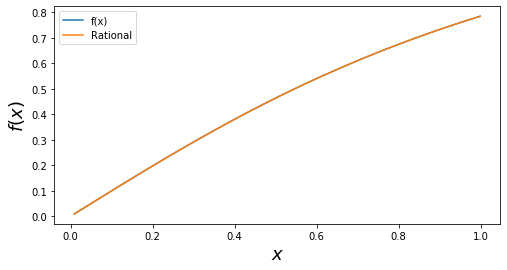

In [17]:
# And plot the results.
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(xx,fx,label='f(x)')
ax.plot(xx,num(xx)/den(xx),label='Rational')
ax.legend()
ax.set_xlabel(r'$x$',fontsize=18)
ax.set_ylabel(r'$f(x)$',fontsize=18)

In [18]:
# Try higher order -- note putting in the odd symmetry explicitly
# by fitting over the range [-1,1] helps both the fit and the
# numerical stability of the matrix.  Look at the size of the
# even vs. odd powers of x below.
xx = np.linspace(-1,1,100)
fx = np.arctan(xx)
#
A,B     = 5,4
num,den = find_rational(xx,fx,A,B)
print(num)
print(den)
print("Maximum error {:10.4f}%".format(100*np.max(np.abs(fx-num(xx)/den(xx))/fx)))

        5             4          3             2
0.0403 x - 7.371e-10 x + 0.6544 x - 4.036e-09 x + 1 x - 1.822e-13
        4             3          2
0.1701 x - 2.033e-09 x + 0.9876 x - 4.043e-09 x + 1
Maximum error     0.0003%


## Continued fractions ##

One technique for approximating functions that is not very often taught to physicists is the use of [continued fractions](https://en.wikipedia.org/wiki/Continued_fraction).  A general continued fraction can be written
$$
  b_0 + \frac{b_1}{a_1 + \frac{b_2}{a_2 + \cdots}}
$$
which we often typeset as
$$
  b_0 + \frac{b_1}{a_1 +} \frac{b_2}{a_2 +} \frac{b_3}{a_3 +} \cdots  
$$
It turns out many special functions (and special constants!) can be approximated very efficiently by such continued fractions.  For example
$$
  \tan x = \frac{x}{1-} \frac{x^2}{3-} \frac{x^2}{5-} \frac{x^2}{7-} \cdots
$$
while
$$
  \pi = 3 + \frac{1}{7+} \frac{1}{15+} \frac{1}{1 + } \frac{1}{291+} \frac{1}{1+} \cdots
  \approx \frac{22}{7} \simeq 3.1428
  \quad\mathrm{or}\quad
  \approx \frac{355}{113} \simeq 3.14159292
$$
and
$$
  e = 2 + \frac{1}{2+} \frac{1}{1+} \frac{1}{1+} \cdots \approx \frac{49171}{18089} \simeq 2.718281828736
$$
allowing one to prove these constants are irrational.
If know how many terms you want to include, you can just evaluate the continued fraction "backwards" and this usually gives the best rational approximation of a given order.  If you don't know in advance how many terms to include there are clever algorithms like [Lentz's algorithm](https://aip.scitation.org/doi/pdf/10.1063/1.4822777).

So how do you derive these continued fractions?  General techniques exist (known as the quotient-difference algorithm), but let's just do a quick example and ignore theorems about convergence, etc.  Suppose we know the power series which we'll write as
$$
  f(z) = \sum_{k=0}^\infty c_k
$$
absorbing the $z^k$ into $c_k$.  Then [Euler showed](https://en.wikipedia.org/wiki/Euler%27s_continued_fraction_formula)
$$
  f \approx c_0 + \frac{c_1}{1+} \frac{-c_2/c_1}{1+c_2/c_1} \cdots \frac{-c_m/c_{m-1}}{1+c_m/c_{m-1}}
$$
which is most easily "proved" by considering e.g.
$$
  c_0 + \frac{c_1}{1+} \frac{-c_2/c_1}{1+c_2/c_1}
  = c_0 + \frac{c_1}{1-c_2/(c_1+c_2)}
  = c_0 + \frac{c_1}{ \frac{c_1}{c_1+c_2} }
  = c_0 + c_1 + c_2
$$
(or more formally using induction).  This is frequently written instead as
$$
  a_0 + a_0 a_1 + a_0 a_1 a_2 + \cdots = \frac{a_0}{1-\frac{a_1}{1+a_1-\frac{a_2}{1+a_2-\cdots}}}
  = \frac{a_0}{1+}\frac{-a_1}{1+a_1+}\frac{-a_2}{1+a_2+}\cdots\frac{-a_n}{1+a_n}
$$
because series like $\exp(x)$, $\ln(1+x)$, $\sin(x)$, $\cos(x)$, etc. can be easily cast into this form.
For example
$$
  \frac{\sin x}{x} = \frac{1}{1+}\frac{x^2}{6-x^2+}\frac{6x^2}{20-x^2+}\cdots
$$

A slightly more complicated version, which sometimes performs better, was found by Viskovatov by noting
$$
  \frac{c_{10} + c_{11} + c_{12} + \cdots}{c_{00} + c_{01} + c_{02} + \cdots }
  = \frac{1}{ \frac{c_{00} + c_{01} + c_{02} + \cdots}{c_{10} + c_{11} + c_{12} + \cdots } }
  = \frac{1}{ \frac{c_{00}}{c_{10}} + \frac{c_{00} + c_{01} + c_{02} + \cdots}{c_{10} + c_{11} + c_{12} + \cdots }
  -\frac{c_{00}}{c_{10}} }
$$
which we can massage as
$$
  = \frac{c_{10}}{c_{00} +
    \frac{(c_{10}c_{01}-c_{00}c_{11})+(c_{10}c_{02}-c_{00}c_{12})+\cdots}{c_{10}+c_{12}+\cdots} }
  = \frac{c_{10}}{ c_{00} + \frac{c_{20}+c_{21}+\cdots}{c_{10}+c_{12}+\cdots}   }
$$
if we define $c_{2i}=c_{10}c_{0,i+1}-c_{00}c_{1,i+1}$.  Now just iterating this with
$c_{kj}=c_{k-1,0}c_{k-2,j+1} - c_{k-2,0}c_{k-1,j+1}$
you get
$$
  f \approx \frac{c_{10}}{c_{00}+} \frac{c_{20}}{c_{10}+}\frac{c_{30}}{c_{20}+}\cdots
$$
and if you take $c_{00}=1$ and $c_{01}=c_{02}=\cdots=0$ you have another connection between the continued fraction and the series!  Sometimes this method converges faster than Euler's method, but note that truncating at $n$th order doesn't return the $n$th partial sum (unlike Euler's method).  There are other tricks like this, but I think this serves to illustrate the point.

Gauss showed that any functions which obeyed a 3-term recurrence relation (such as most of the special functions physicists use!) can be written as a continued fraction.  So if
$$
  f_{i-1} - f_i = k_i f_{i+1} \quad\Rightarrow\quad
  g_i \equiv \frac{f_i}{f_{i-1}} = \frac{1}{1+k_i g_{i+1}}
  \quad\mathrm{and}\quad
  g_1 = \frac{1}{1+} \frac{k_1}{1+} \frac{k_2}{1+} \cdots
$$
[Gauss applied this to hypergeometric functions](https://en.wikipedia.org/wiki/Gauss%27s_continued_fraction), and since many common functions are limits of the hypergeometric functions he was able to derive continued fraction expressions for many of them.

Using these techniques we can do, for example,
$$
  \exp z = 1 + \frac{z}{1+} \frac{-z/2}{1+} \frac{z/6}{1+} \frac{-z/6}{1+} \frac{z/10}{1+}\cdots
$$

In [19]:
# Suppose we just work to fixed order in this continued fraction expansion.
# We'll choose to terminate as written above (i.e. the z/10 term).
def cf_exp(z):
    """A continued fraction approximation to exp(z)."""
    bn  = np.array([0.1,-1./6.,1./6.,-0.5,1.0])
    a,b = 0.0,0.0
    for n in range(bn.size):
        a = 1 + b
        b = bn[n]*z / a
    return(b+1)
# How well does this do?  It should work well for small z and break
# down at some higher z.
print("Continued fraction approximation to exp:")
for z in [0.25,0.5,1.0,2.0]:
    ap = cf_exp(z)
    ex = np.exp(z)
    print("z={:.3f}, CF={:10.6f}, exact={:10.6f}, err={:10.4f}%".format(z,ap,ex,100*(ap-ex)/ex))
print("Taylor series approximation to exp:")
# Let's compare this to the power (Taylor) series out to the same order:
taylor = np.poly1d([1.0,1.0,1./2.,1./6.,1./24.,1./120.][::-1])
for z in [0.25,0.5,1.0,2.0]:
    ap = taylor(z)
    ex = np.exp(z)
    print("z={:.3f}, TS={:10.6f}, exact={:10.6f}, err={:10.4f}%".format(z,ap,ex,100*(ap-ex)/ex))

Continued fraction approximation to exp:
z=0.250, CF=  1.284025, exact=  1.284025, err=   -0.0000%
z=0.500, CF=  1.648718, exact=  1.648721, err=   -0.0002%
z=1.000, CF=  2.717949, exact=  2.718282, err=   -0.0123%
z=2.000, CF=  7.333333, exact=  7.389056, err=   -0.7541%
Taylor series approximation to exp:
z=0.250, TS=  1.284025, exact=  1.284025, err=   -0.0000%
z=0.500, TS=  1.648698, exact=  1.648721, err=   -0.0014%
z=1.000, TS=  2.716667, exact=  2.718282, err=   -0.0594%
z=2.000, TS=  7.266667, exact=  7.389056, err=   -1.6564%


And for completeness let's do the tangent:
$$
  \tan z = \frac{z}{1-} \frac{z^2}{3-} \frac{z^2}{5-} \frac{z^2}{7-} \cdots
$$
where the performance will turn out to be even better!

In [20]:
# Suppose we just work to fixed order in this continued fraction expansion.
# We'll choose to terminate as written above (i.e. the z^2/7 term).
def cf_tan(z):
    """A continued fraction approximation to tan(z)."""
    an  = np.array([7.,5.,3.])
    a,b = 0.0,0.0
    z2  = z**2
    for n in range(an.size):
        a = an[n] - b
        b = z2 / a
    return(z/(1-b))
# How well does this do?  It should work well for small z and break
# down at some higher z.
print("Continued fraction approximation to tan:")
for z in [0.5,1.0,1.5,1.55]:
    ap = cf_tan(z)
    ex = np.tan(z)
    print("z={:.3f}, CF={:10.6f}, exact={:10.6f}, err={:12.3f}%".format(z,ap,ex,100*(ap-ex)/ex))
print("Taylor series approximation to tan:")
# Let's compare this to the power (Taylor) series out to the same order:
taylor = np.poly1d([0,1.0,0,1./3.,0,2./15.,0,17./35.][::-1])
for z in [0.5,1.0,1.5,1.55]:
    ap = taylor(z)
    ex = np.tan(z)
    print("z={:.3f}, TS={:10.6f}, exact={:10.6f}, err={:12.3f}%".format(z,ap,ex,100*(ap-ex)/ex))

Continued fraction approximation to tan:
z=0.500, CF=  0.546302, exact=  0.546302, err=      -0.000%
z=1.000, CF=  1.557377, exact=  1.557408, err=      -0.002%
z=1.500, CF= 14.042553, exact= 14.101420, err=      -0.417%
z=1.550, CF= 47.193441, exact= 48.078482, err=      -1.841%
Taylor series approximation to tan:
z=0.500, TS=  0.549628, exact=  0.546302, err=       0.609%
z=1.000, TS=  1.952381, exact=  1.557408, err=      25.361%
z=1.500, TS= 11.936384, exact= 14.101420, err=     -15.353%
z=1.550, TS= 14.424227, exact= 48.078482, err=     -69.999%


## High precision ##

And one last thing: what if we wanted to do really high precision?  Rather than get into too many details, I highlight one super-cool connection between high precision elementary functions and the theory of elliptic integrals.  For more information take a look at [Borwein & Borwein  "The arithmetic-geometric mean and fast computation of elementary functions"; SIAM review 26, 351 (1984)](https://epubs.siam.org/doi/10.1137/1026073) or any one of several other nice articles online.

Define the "arithmetic-geometric mean" (AGM) of two positive numbers ($a>0$ and $b>0$) as the following iteration: starting from $a_0=a$ and $b_0=b$ iterate
$$
  a_{n+1} = \frac{1}{2}\left( a_n+b_n \right) \quad , \quad
  b_{n+1} = \sqrt{a_nb_n}
$$
It takes only a little work to show $a_n$ and $b_n$ converge to a common limit, and in fact the convergence is very fast.  Specifically $c_n=\sqrt{a_n^2-b_n^2}$ converges quadratically to zero.

Gauss was the first to provide a way to compute elementary functions using algorithms that converged extremely rapidly (Newton's method already does this for algebraic functions).  He did this by showing
$$
  I(a,b) = \frac{\pi}{2{\rm AGM}(a,b)} = \int_0^{\pi/2}\frac{d\theta}{\sqrt{a^2\cos^2\theta+b^2\sin^2\theta}}
$$
The proof "just" involves finding a nice variable substitution to convert $I(a,b)$ into $I([a+b]/2,\sqrt{ab})$ and knowing $I(a,a)=\pi/(2 a)$.
The integral is an example of a _complete elliptic integral of the first kind_.  It satisfies many interesting identities, for example
$$
  \lim_{k\to 0^{+}}\left[\ln\left(\frac{4}{k}\right)-I(1,k)\right] = 0
$$
With a little rearranging and some attention to limits you can show
$$
  \left| \ln(x) - \left[ I(1,10^{-n})-I(1,10^{-n}x)\right]\right| < n 10^{-2(n-1)}
$$
for $0<x<1$ and $n\ge 3$.  Thus we can compute $\ln x$ exponentially quickly given the AGM method for computing $I(a,b)$.  Similar tricks give $\exp(x)$ and hence $\sin x$, $\cos x$, $\sinh x$, $\cosh x$, etc.

As an example (circling back to the log) let us compute $\ln x$ (for $x>1$) using the AGM.

To proceed, let us choose a large $n$ and write $a=(1/4)x^n$ which should be $\gg 1$.  Then we have
$$
  I(a,1) = \frac{\pi}{2} / {\rm AGM}(a,1)
  \quad\Rightarrow\quad
  \ln x \approx \frac{a}{n} I(a,1) = \frac{a}{n}\frac{\pi/2}{{\rm AGM}(a,1)}
$$

In [21]:
# Compute ln(2) using the AGM.  We will use the "mpmath" library
# to do very high precision arithmetic, to show the convergence.
from mpmath import mp
mp.dps = 50
# Compute ln(2) using the AGM.
# Choose n=15, so that a = (1/4)2^15 = 2^13 = 8192.
aa,enn= mp.mpf(8192.),mp.mpf(15.0)
an,bn = mp.mpf(8192.),mp.mpf(1.00)
for i in range(8):
    an,bn = 0.5*(an+bn),mp.sqrt(an*bn)
    approx= aa/enn * mp.pi/2/an
    print("Apprx=",approx)
print("ln(2)=",mp.log(2.0))
print("Error=",mp.log(2.0)-approx)
print("Fractional error should be of order ",mp.mpf(4.0)/2.0**(2*enn))

Apprx= 0.20941394701336576922971621787563112923506417445527
Apprx= 0.40977418346955531776799780875309704083453486254152
Apprx= 0.63488687287937269491742277212960069071352940497732
Apprx= 0.69175345098695577756052282142942287084643945769836
Apprx= 0.69314648017139030390947436374567385513586423104284
Apprx= 0.69314718289358900148255482742325997833160940691554
Apprx= 0.6931471828937671092142210911890400423177120155689
Apprx= 0.69314718289376710921422110263046433942112437456177
ln(2)= 0.69314718055994530941723212145817656807550013436025
Error= -0.0000000023338217997969889811722877713456242402015109436112
Fractional error should be of order  0.0000000037252902984619140625


We can also compute constants.

The method for $\pi$ is:
1. Set $\alpha_0=\sqrt{2}$, $\beta_0=0$ and $\pi_0=2+\sqrt{2}$.
2. Iterate
   * $\alpha_{n+1} = \frac{1}{2}\left(\alpha_n^{1/2}+\alpha_n^{-1/2}\right)$
   * $\beta_{n+1} = \alpha_n^{1/2}\left(\frac{\beta_n+1}{\beta_n+\alpha_n}\right)$
   * $\pi_{n+1} = \pi_n\beta_{n+1}\left(\frac{1+\alpha_{n+1}}{1+\beta_{n+1}}\right)$

with $\pi_n\to\pi$ as $n\to\infty$.

In [22]:
# Compute Pi to a ridiculous number of digits.
from mpmath import mp
mp.dps = 85
#
one   = mp.mpf(1.0)
half  = mp.mpf(0.5)
alpha = mp.sqrt(mp.mpf(2.0))
beta  = mp.mpf(0.0)
pi    = mp.mpf(2.0) + alpha
#
for iter in range(6):
    aa    = alpha
    rtalp = mp.sqrt(alpha)
    alpha = half*(rtalp+one/rtalp)
    beta  = rtalp*(one+beta)/(aa+beta)
    pi    = pi*beta*(one+alpha)/(one+beta)
    print(pi)

3.142606753941622600790719823618301891971356246277167253911067067330024328298414339175
3.141592660966044230497752235120339690679284256864528905833583762816615429517722102698
3.14159265358979323864577399175714179403478962386745184194317618340870893816338362722
3.141592653589793238462643383279502884197224120466562720393272077639606048071774937466
3.14159265358979323846264338327950288419716939937510582097494459230781640628620899863
3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628
